In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import random

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
image_res = 256
image_center_x = 0
image_center_y = 0
zoom_factor = 5
# num_classes = 2

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 3)
        
        nn.init.uniform_(self.fc1.weight, a=-1, b=1)
        nn.init.uniform_(self.fc2.weight, a=-1, b=1)
        nn.init.uniform_(self.fc3.weight, a=-1, b=1)
        nn.init.uniform_(self.fc4.weight, a=-1, b=1)
        nn.init.uniform_(self.fc4.weight, a=-1, b=1)
        nn.init.uniform_(self.fc5.weight, a=-1, b=1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=3, bias=True)
)

In [5]:
loss = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001)

In [6]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return img_array

In [7]:
def display_image(img_array):
    img_array = np.array(img_array)
    plt.imshow(img_array)
    plt.show()

In [8]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [9]:
def get_img_array():
    coords = torch.meshgrid((torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 - image_center_y) * zoom_factor,
                            (torch.arange(image_res, dtype=torch.float32, device=GPU) / image_res - 0.5 + image_center_x) * zoom_factor)
    
    coords = torch.stack(coords, dim=-1)
    
    image = net(coords)
    return image

In [10]:
directory = r"C:\Users\user\Desktop\learning from human\images\strawberry"
files = os.listdir(directory)

questions = []
answers = []

for x in tqdm(files):
    img = torch.tensor(load_image(fr"{directory}\{x}"), dtype=torch.float32, device=GPU)
    
    for y_cord in range(len(img)):
        for x_cord in range(len(img)):
            questions.append(torch.tensor((y_cord / image_res - 0.5, x_cord / image_res - 0.5), dtype=torch.float32, device=GPU))
            answers.append(img[y_cord][x_cord])

combined_lists = list(zip(questions, answers))
random.shuffle(combined_lists)
questions, answers = zip(*combined_lists)

100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


In [16]:
for x in tqdm(range(len(questions))):
    train_nn(questions[x], answers[x], net)

100%|██████████| 10240/10240 [00:17<00:00, 583.26it/s]


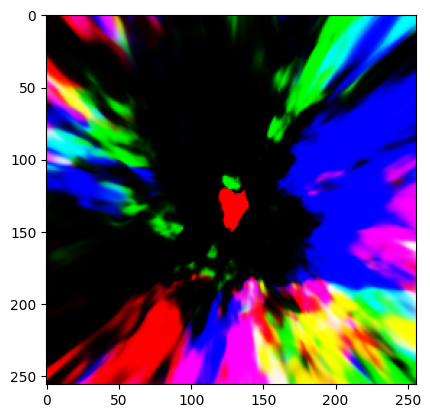

In [21]:
display_image(get_img_array().detach().cpu())